This notebook implements an ImageClassifier based on the fastai library for the MNIST dataset.

## Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import itertools



`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [4]:
PATH = "data/digits/"

## Observe Data

Our library will assume that you have *train.csv* and *test.csv* files (which can be downloaded from kaggle).

In [5]:
!ls {PATH}

labels.csv  models  sample_submission.csv  test.csv  tmp  train  train.csv


In [6]:
train_csv = f'{PATH}train.csv'
test_csv = f'{PATH}test.csv'

In [7]:
train_data = pd.read_csv(train_csv)
test_data = pd.read_csv(test_csv)

This is how the data looks like

In [8]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we see how the data is distributed

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

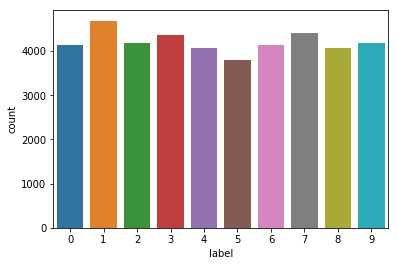

In [9]:
Labels = train_data["label"]

# Drop 'label' column
Images = train_data.drop(labels = ["label"],axis = 1) 

g = sns.countplot(Labels)

Labels.value_counts()

In [10]:
lb = preprocessing.LabelBinarizer()
#Labels = lb.fit_transform(Labels)

Save Labels as csv file

In [11]:
Labels = np.append([np.arange(len(Labels))],  [Labels], axis=0).T
np.savetxt(f'{PATH}labels.csv', Labels, fmt ='%i' ,delimiter=",")

Save array data as images to be able to use ImageClassifierData.from_csv later on

In [12]:
import matplotlib

# reshape to a matrix
X_img = Images.values.reshape(-1,28,28)

for i in range(len(X_img)):
    matplotlib.image.imsave(f'{PATH}train/' + str(i) + '.png', X_img[i])

Let's have a look at some images

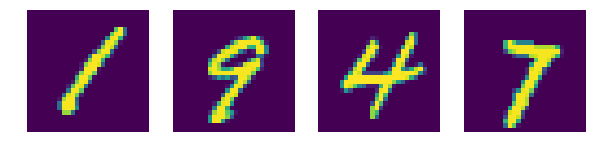

In [13]:
list_paths = [f"{PATH}train/0.png", f"{PATH}train/11.png",f"{PATH}train/1111.png", f"{PATH}train/2425.png"]
plots_from_files(list_paths)

# Building the Model

In [14]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

choose architecture (more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks))

In [15]:
arch=resnet34 #resnet152 #

In [16]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

### Steps for building the model
1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [17]:
sz=64
bs = 256
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.1)

In [18]:
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms, suffix='.png', val_idxs=val_idxs)

In [19]:
learn = ConvLearner.pretrained(arch, data, ps=0.7, precompute=True)

Let's check which learning rate to choose

 80%|████████  | 421/525 [00:08<00:02, 51.00it/s, loss=5.18]


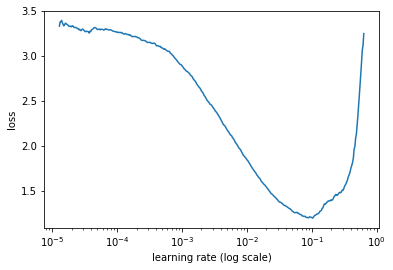

In [20]:
lr = learn.lr_find()
#learn.sched.plot_lr()
learn.sched.plot()

In [21]:
learn.freeze()
learn.fit(0.02, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.648852   0.277241   0.916312  
    1      0.533995   0.254719   0.924006                    
    2      0.494541   0.23513    0.931818                    
    3      0.434032   0.232091   0.935488                    
    4      0.428864   0.212626   0.938802                    



[0.2126264660195871, 0.9388020833333334]

In [22]:
learn.precompute=False

In [23]:
learn.fit(0.03, 15, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.465743   0.201757   0.937263  
    1      0.462123   0.20526    0.9375                      
    2      0.435147   0.201789   0.936435                    
    3      0.46293    0.198073   0.939749                    
    4      0.417055   0.192158   0.940696                    
    5      0.403621   0.19204    0.940933                    
    6      0.410659   0.191309   0.942945                    
    7      0.398446   0.187243   0.943419                    
    8      0.416559   0.184572   0.945431                    
    9      0.382318   0.181018   0.946023                    
    10     0.399649   0.184629   0.943063                    
    11     0.384043   0.183231   0.943774                    
    12     0.396498   0.181724   0.946259                    
    13     0.387326   0.181614   0.946023                    
    14     0.397999   0.177005   0.945786                    



[0.1770054797331492, 0.9457859848484849]

save the last layer

In [24]:
learn.save('224_lastlayer')

In [25]:
learn.load('224_lastlayer')

In [26]:
learn.unfreeze()

 83%|████████▎ | 437/525 [01:01<00:12,  7.14it/s, loss=1.05] 

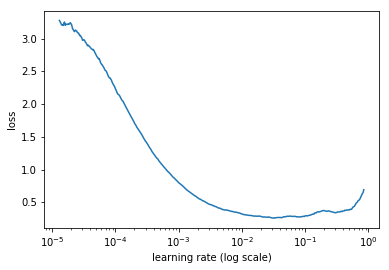

In [27]:
learn.lr_find()
learn.sched.plot()

In [28]:
lr=np.array([0.0003,0.001,0.003])

In [ ]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

  3%|▎         | 15/525 [00:03<01:56,  4.38it/s, loss=3.26]
epoch      trn_loss   val_loss   accuracy                    
    0      0.117302   0.056315   0.983428  
    1      0.070111   0.032559   0.98982                      
    2      0.049283   0.030949   0.990767                     
    3      0.052209   0.025388   0.992069                     
    4      0.033085   0.024908   0.99349                      
    5      0.027318   0.021492   0.993608                     
    6      0.026979   0.022169   0.994081                     
    7      0.032137   0.024263   0.993608                     
    8      0.024878   0.024023   0.993963                     
    9      0.015675   0.023977   0.993371                     
    10     0.016779   0.022343   0.99491                      
    11     0.012258   0.02244    0.994437                     
 82%|████████▏ | 430/525 [01:00<00:13,  7.14it/s, loss=0.0126]

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

## Improving our model

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)        # probability of '1'

In [ ]:
print(preds[:10])
print(probs[:10])

In [ ]:
probs[0][1]

In [ ]:
x = ( str(p) for p in probs[0])
list(x)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, preds, probs, figsize=(12,6), rows=1):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        sp.set_title(str(preds[i])+' / '+list(str(x) for x in probs[i][x]), fontsize=8)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_preds = [preds[x] for x in idxs]
    title_probs = [probs[x] for x in idxs]
    return plots(imgs, rows=1, preds=title_preds, probs=title_probs, figsize=(16,8))

In [ ]:
probs

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
print("Most incorrect")
for i in range(len(data.classes)):
    plot_val_with_title(most_by_correct(i, False))

In [ ]:
print("Most uncertain predictions")
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain)

### Confusion matrix 

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [ ]:
plot_confusion_matrix(cm, data.classes)